In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v4
from Resources.Game import *


In [26]:
gamma = 0.98

error_hist = []
game_count = 0
draw_count = 0

criterion = nn.MSELoss()
model = Model_v4() # Conv large
model.train()
model.load_state_dict(torch.load('../Monte Carlo//Model Saves MC v4/model_36510_games'))
white_wins = 0
black_wins = 0
draws = 0

 -- 0 -- winner: white, i: 171    wins: w = 1, b = 0, d = 2


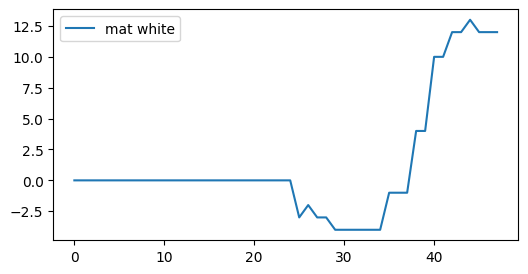

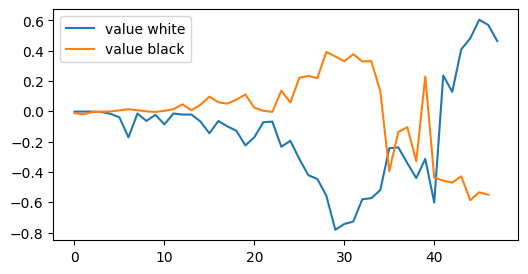

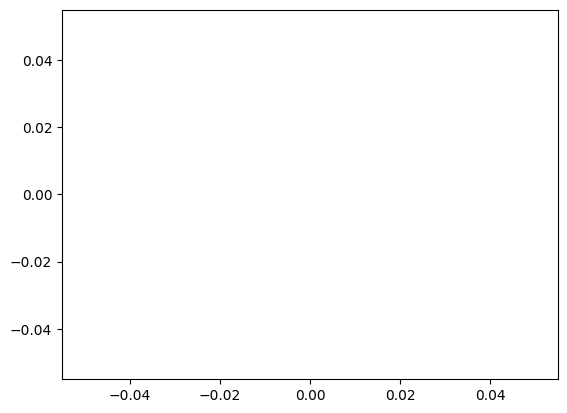

 -- 10 -- winner: black, i: 56    wins: w = 4, b = 7, d = 7
 -- 20 -- winner: white, i: 87    wins: w = 11, b = 10, d = 11
 -- 30 -- winner: black, i: 12    wins: w = 16, b = 15, d = 17
 -- 40 -- winner: white, i: 117    wins: w = 23, b = 18, d = 20
 -- 50 -- winner: black, i: 34    wins: w = 27, b = 24, d = 22
 -- 60 -- winner: white, i: 51    wins: w = 32, b = 29, d = 26
 -- 70 -- winner: white, i: 113    wins: w = 35, b = 36, d = 27
 -- 80 -- winner: black, i: 16    wins: w = 36, b = 45, d = 29
 -- 90 -- winner: black, i: 232    wins: w = 40, b = 51, d = 31
 -- 100 -- winner: white, i: 133    wins: w = 46, b = 55, d = 32


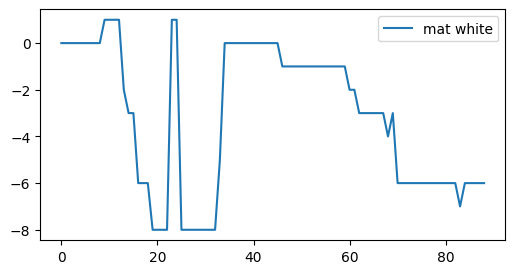

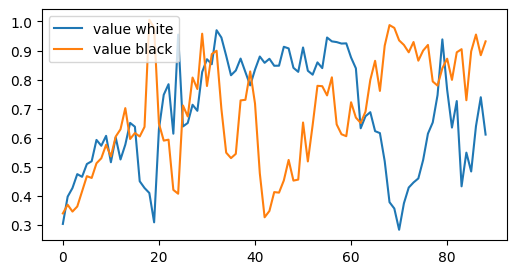

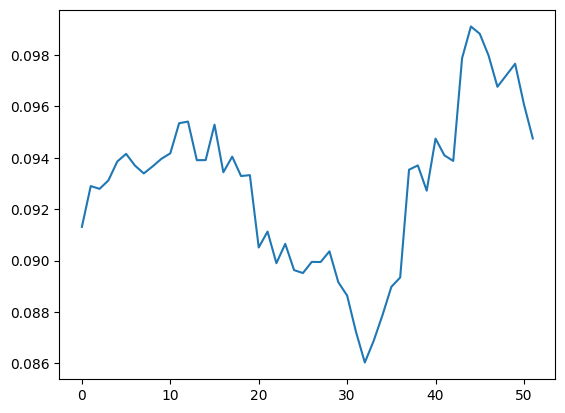

 -- 110 -- winner: white, i: 43    wins: w = 52, b = 59, d = 35
 -- 120 -- winner: black, i: 156    wins: w = 58, b = 63, d = 38
 -- 130 -- winner: white, i: 77    wins: w = 64, b = 67, d = 40
 -- 140 -- winner: black, i: 110    wins: w = 68, b = 73, d = 44
 -- 150 -- winner: white, i: 65    wins: w = 75, b = 76, d = 44
 -- 160 -- winner: black, i: 116    wins: w = 81, b = 80, d = 46


KeyboardInterrupt: 

In [27]:
i_limit = 1000
while True:
    t0 = time.time()

    game = Game()
    next_root = None
    i = 0
    boards_white = [];  boards_black = []
    mat_white = [];     mat_black = []
    value_white = [];   value_black = []

    current_boards = []; current_labels = []

    model.eval()

    while not game.is_over():
        i += 1
        if i > i_limit:
            break

        moves = game.PossibleMoves()

        game_ini = game.copy()
        current_boards.append(board_to_tensor(game.pieces))
        board_batch = [board_to_tensor(game.pieces)]

        mate = False

        for move in moves:
            game.PlayMove(move)
            board_batch.append(board_to_tensor(game.pieces))
            game.FlipBoard()
            if game.is_over():
                mate = True
                chosen_move = move
                game = game_ini.copy()
                break
            game = game_ini.copy()


        board_tensor = torch.stack(board_batch)
        values = model(board_tensor)

        if i > 2: # both sides played one move, start filling up labels
            current_labels.append( max([values[i] for i in range(1, len(values))]) )

        if not mate:

            values_diff = [values[i] for i in range(1, len(values))]
            move_prob = torch.softmax(torch.Tensor(values_diff), dim=0).numpy()
            chosen_i = np.random.choice(range(len(moves)), p=move_prob)
            chosen_move = moves[chosen_i]
            
        game.PlayMove(chosen_move)

        mat_diff = game.MaterialDiff()
        # value = model(torch.stack([board_to_tensor(game.pieces)])).detach().item()

        # print(values[0])

        if i % 2 == 1:
            #boards_white.append(board_to_tensor(game.pieces))
            mat_white.append(mat_diff)
            value_white.append(values[0].detach().item())
        if i % 2 == 0:
            #boards_black.append(board_to_tensor(game.pieces))
            mat_black.append(mat_diff)
            value_black.append(values[0].detach().item())

        game.FlipBoard()

    # plt.plot(model(torch.stack(boards_white)).detach().numpy())
    # plt.title('values white')
    # plt.show()
    # plt.plot(model(torch.stack(boards_black)).detach().numpy())
    # plt.title('values black')
    # plt.show()

    current_labels.append(-1)
    current_labels.append(1)

    if i <= i_limit: # game actually ended

        winner = game.get_winner()
        if winner == 'draw':
            draws += 1;         reward_white = 0;   reward_black = 0
        if winner == 'white':
            white_wins += 1;    reward_white = 1;   reward_black = -1
        if winner == 'black':
            black_wins += 1;    reward_white = -1;  reward_black = 1

    if i > i_limit:
        print('game termianted')
        continue

    game_time = time.time() - t0

    inputs_tens = torch.stack(current_boards)
    labels_tens = torch.Tensor(current_labels)   

    if winner != 'draw':
        # newest training error
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist.append(loss.item())
    else:
        draw_count += 1
        continue

    if game_count % 10 == 0:
        print(' -- {} -- winner: {}, i: {}   '.format(game_count, winner, i), 'wins: w = {}, b = {}, d = {}'.format(white_wins, black_wins, draws))


    if game_count % 100 == 1:# or True:
        plt.figure(figsize=(6, 3))
        plt.plot(mat_white, label='mat white')
        plt.legend()
        plt.show()
        plt.figure(figsize=(6, 3))
        plt.plot(value_white, label='value white')
        plt.plot(value_black, label='value black')
        plt.legend()
        plt.show()

    torch.save(inputs_tens, './MCTS Game Saves QL v4/inputs_{}'.format(game_count))
    torch.save(labels_tens, './MCTS Game Saves QL v4/labels_{}'.format(game_count))

    t1 = time.time()

    if game_count > 5:
        # sample some of previous game for replay. More recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(game_count)) 
        prob = prob /sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(game_count, 0, -1), size=num_samples, p=prob)

        for indices in samples:
            inputs_load = torch.load('./MCTS Game Saves QL v4/inputs_{}'.format(indices))
            inputs_tens = torch.cat((inputs_load, inputs_tens))
            labels_tens = torch.cat((torch.load('./MCTS Game Saves QL v4/labels_{}'.format(indices)), labels_tens))

    len_boards = len(inputs_tens)
    for c in range(len_boards):
        tens = inputs_tens[c]
        # if no pawns are on the board: add all other 3 rotated versions of the board to the current data set
        if torch.sum(inputs_tens[c][0]) + torch.sum(inputs_tens[c][6]) == 0:
            board_new = tensor_to_board(tens)
            for _ in range(3):
                board_new = rotate_board(board_new, 1)
                tens_new = torch.stack([board_to_tensor(board_new)])
                inputs_tens = torch.cat((inputs_tens, tens_new), 0)
                labels_tens = torch.cat((labels_tens, torch.stack([labels_tens[c]])), 0)
    
    model.train()
    # learning_rate = 5e-4 * 500 / (500 + game_count) # reducing learning rate, 1/n one possible options
    learning_rate = 1e-5
    # weight_decay = 1e-2 # regularization to avoid overfitting
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    random_order = [i for i in range(len(inputs_tens))]
    np.random.shuffle(random_order)
    for c in random_order:

        inp = torch.stack([inputs_tens[c], mirror_board_tensor(inputs_tens[c])])
        label = torch.stack([labels_tens[c], labels_tens[c]])

        out = model(inp)
        out = out.view(out.shape[0])

        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
        optimizer.step()

    # print('game time: {} -- training time: {},  '.format(game_time, time.time() - t1))
    # print('sum of losses: ', sum(err_curr))

    # error_hist.append(sum(err_curr))
    
    torch.save(error_hist, './error_hist QL v4')

    if game_count % 100  == 1:
        # plt.plot(error_hist)
        # plt.title('training errors')
        # plt.show()
        interval = 50
        plt.figure()
        plt.plot([np.mean(error_hist[i:i+interval]) for i in range(len(error_hist) - interval)])
        plt.show()

    if game_count % 100 == 9:    
        torch.save(model.state_dict(), './Value Function Model Saves QL v4/model_{}_games'.format(game_count+1))

    game_count += 1


In [12]:
print(len(current_boards))

243


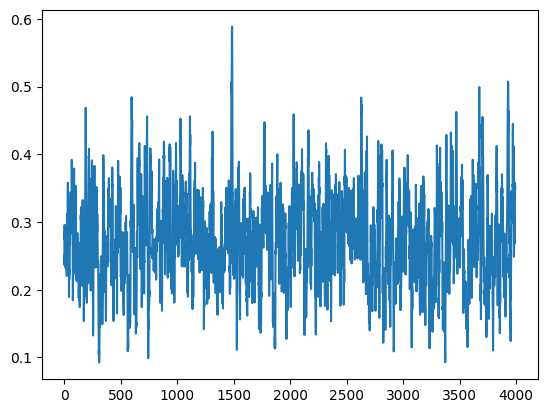

In [9]:
interval = 10
plt.figure()
plt.plot([np.mean(error_hist[i:i+interval]) for i in range(len(error_hist) - interval)])
plt.show()